In [1]:
import ants
import tifffile
import numpy as np
import os
import cv2
import json
import time
import pandas as pd
# import SimpleITK as sitk
# import seaborn as sns
from scipy import stats
import gc
from tifffile import TiffFile
# from skimage import io
import tifffile
from scipy.ndimage import zoom
import traceback
import gzip
import shutil


%matplotlib inline
import matplotlib.pyplot as plt

from multiprocessing import Pool
plt.gray()

import json, os.path, os, re, time
# import joblib
import subprocess as sp
import nibabel as nib
import scipy.spatial
from scipy.signal import convolve

<Figure size 432x288 with 0 Axes>

In [2]:
class mapping_to_atlas():
    def __init__(self,data_atlas_path, ants_dir_name, data_ants_path, before_ants_file):
        self.ants_voxel_unit = Resize_um
        self.original_voxel_unit = Resize_um
        self.img_voxel_unit = Resize_um

        
        self.atlas_tif_path = data_atlas_path
        self.atlas_nii_path = self.atlas_tif_path.replace(".tif",".nii.gz")
        
        #for image size check
        
        
#         self.flip_tif_path =  os.path.join(data_parent_path,"{}/{}/ANTs/density_img_50um_flip.tif".format(organ_name,sample_name))
#         self.flip_txt_path = os.path.join(data_parent_path,"{}/{}/ANTs/flip_memo.txt".format(organ_name,sample_name))

        self.ants_dst_dir = os.path.join(data_ants_path, ants_dir_name+"/")
    
        self.sample_resize_img_path =  os.path.join(data_ants_path,before_ants_file)
        
        #self.flip_tif_path --->  self.sample_nii_path
        self.sample_nii_path = os.path.join(data_ants_path ,before_ants_file.replace(".tif",".nii.gz"))
        
        self.before_ants_np_path = os.path.join(data_ants_path,"all_points_um.npy")
        
        if not os.path.exists(self.ants_dst_dir):
            print("make ants folder {}".format(self.ants_dst_dir))
            os.makedirs(self.ants_dst_dir)
        else:
            print("{} already exists".format(self.ants_dst_dir))

        self.moving_nii_path = self.sample_nii_path
        
        self.output_nii_path = os.path.join(self.ants_dst_dir, "after_ants.nii.gz")
        
        self.prefix_ants ="/opt/ANTs/bin/"# "/usr/local/ANTs/"
        
#         self.moving_points_path = os.path.join(self.ants_dst_dir,"moving.csv")   #?
#         self.moved_points_path = os.path.join(self.ants_dst_dir,"moved.csv")#?
#         self.moved_denstity_path = os.path.join(self.ants_dst_dir,"moved_denstity.tif")
    
        
    def tif2nii(self, tif_path, nii_path, nii_voxel_unit):
        tif_img = tifffile.imread(tif_path)
#         nii_img = nib.Nifti1Image(np.swapaxes(tif_img,0,2), affine=None)
        nii_img = nib.Nifti1Image(tif_img, affine=None)
        aff = np.diag([-nii_voxel_unit,-nii_voxel_unit,nii_voxel_unit,1])
        nii_img.header.set_qform(aff, code=2)
        nii_img.to_filename(nii_path)
        return



    def run_antsRegistration(self,prefix_ants, atlas_file, moving_file, dst_dir, threads):
        cmd = "ITK_GLOBAL_DEFAULT_NUMBER_OF_THREADS={THREADS} && "
        cmd += "{EXECUTABLE} -d 3 "
        cmd += "--initial-moving-transform [{ATLAS_FILE},{MOVING_FILE},1] "
        cmd += "--interpolation Linear "
        cmd += "--use-histogram-matching 0 "
        cmd += "--winsorize-image-intensities [0.05,1.0] "  
        cmd += "--float 0 "
        cmd += "--output [{DST_PREFIX},{WARPED_FILE},{INVWARPED_FILE}] "
        cmd += "--transform Affine[0.1] --metric MI[{ATLAS_FILE},{MOVING_FILE},1,128,Regular,0.5] --convergence [10000x10000x10000,1e-5,15] --shrink-factors 4x2x1 --smoothing-sigmas 2x1x0vox "
        cmd += "--transform SyN[0.1,3.0,0.0] --metric CC[{ATLAS_FILE},{MOVING_FILE},1,5] --convergence [300x100x30,1e-6,10] --shrink-factors 4x2x1 --smoothing-sigmas 2x1x0vox"

#         cmd += "--transform Affine[0.1] --metric MI[{ATLAS_FILE},{MOVING_FILE},1,128,Regular,0.5] --convergence [10000x10000x10000,1e-5,15] --shrink-factors 8x4x2 --smoothing-sigmas 3x2x1vox "
#         cmd += "--transform SyN[0.1,3.0,0.0] --metric CC[{ATLAS_FILE},{MOVING_FILE},1,4] --convergence [500x500x500x50,1e-6,10] --shrink-factors 8x4x2x1 --smoothing-sigmas 3x2x1x0vox"
        cmd = cmd.format(
            THREADS = threads,
            EXECUTABLE = os.path.join(prefix_ants, "antsRegistration"),
            DST_PREFIX = os.path.join(dst_dir, "F2M_"),
            WARPED_FILE = os.path.join(dst_dir, "F2M_Warped.nii.gz"),
            INVWARPED_FILE = os.path.join(dst_dir, "F2M_InvWarped.nii.gz"),
            ATLAS_FILE = atlas_file,
            MOVING_FILE = moving_file,
        )
        print("[*] Executing : {}".format(cmd))
        sp.call(cmd, shell=True)
        return


    #def set_
    
    #scale of list is atlas_voxel_unit
    def make_density_image(self,list_x,list_y,list_z,size_x,size_y,size_z):
        depth,height,width = size_z,size_y,size_x
        density_img,_ = np.histogramdd(
            np.vstack([list_z,list_y,list_x]).T,
            bins=(depth, height, width),
            range=[(0,depth-1),(0,height-1),(0,width-1)]
        )
        return density_img
    
    def run_antsApplyTransformsToPoints(self, prefix_ants, src_csv, dst_csv, ANTs_image_dir):
        cmd = "{EXECUTABLE} "
        cmd += "-d 3 "
        cmd += "-i {SRC_CSV} "
        cmd += "-o {DST_CSV} "
        cmd += "-t [{AFFINE_MAT},1] "
        cmd += "-t {INVWARP_NII}"
        cmd = cmd.format(
            EXECUTABLE = os.path.join(prefix_ants, "antsApplyTransformsToPoints"),
            AFFINE_MAT = os.path.join(ANTs_image_dir, "F2M_0GenericAffine.mat"),
            INVWARP_NII = os.path.join(ANTs_image_dir, "F2M_1InverseWarp.nii.gz"),
            SRC_CSV = src_csv,
            DST_CSV = dst_csv,
        )
        #print("[*] Executing : {}".format(cmd))
        # supress output
        with open(os.devnull, 'w') as devnull:
            sp.check_call(cmd, shell=True, stdout=devnull)
        return
    
    def run_antsApplyTransforms(self, prefix_ants, src_file, atlas_file, dst_file, ANTs_image_dir):
        cmd = "{EXECUTABLE} "
        cmd += "-d 3 "
        cmd += "-e 0 "  #choose 0/1/2/3 mapping to scalar/vector/tensor/time-series
        cmd += "-i {SRC_FILE} "
        cmd += "-r {REF} "
        cmd += "-o {DST_FILE} "
        cmd += "-n {INTERP} "
        cmd += "-t {INVWARP_NII} "
        cmd += "-t {AFFINE_MAT} "
#         cmd += "-t [{AFFINE_MAT},1] "
#         cmd += "-t {INVWARP_NII} "
       
        cmd = cmd.format(
            EXECUTABLE = os.path.join(prefix_ants, "antsApplyTransforms"),
            SRC_FILE = src_file,
            REF = atlas_file,
            DST_FILE = dst_file,
            INTERP = "Linear",
            INVWARP_NII = os.path.join(ANTs_image_dir, "F2M_1Warp.nii.gz"),
            AFFINE_MAT = os.path.join(ANTs_image_dir, "F2M_0GenericAffine.mat"),
        
        )
        #print("[*] Executing : {}".format(cmd))
        # supress output
        with open(os.devnull, 'w') as devnull:
            sp.check_call(cmd, shell=True, stdout=devnull)
        return 
    
#2D slice tif images -> 3D tif image
def stack_2d_images(path):
    
    imgs = os.listdir(path)

    img0 = tifffile.imread(path + "/"+imgs[0])
    
    width = img0.shape[0]
    height  = img0.shape[1]
    
    stack_image = np.zeros((width, height, len(imgs)))
    
    for i, img_f in enumerate(imgs):
        if "ANTs" in img_f or "ANTsR" in img_f:
            continue
        img = tifffile.imread(path + "/"+img_f)
        stack_image[:,:,i]=img
    return stack_image



def convert_nii_to_tiff(nii_file, output_tiff_file):
    # NIfTI ファイルを読み込む
    nii_data = nib.load(nii_file)
    # NIfTI データを NumPy 配列に変換
    nii_array = nii_data.get_fdata()
    # NumPy 配列を TIFF ファイルに保存
    tifffile.imwrite(output_tiff_file, nii_array)

def decompress_gzip(input_file, output_file):
    with gzip.open(input_file, 'rb') as f_in:
        with open(output_file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)


def convolve_3d_array(data, kernel):
    # 各チャンネルに対して畳み込みを実行
    result = convolve(data, kernel, mode='same')

    return result
    
    

In [ ]:


#make higher resoluted images(20 um)
def multi_save_re(cores, savedir, exp, sample, block, cr_num, fol):
    args=[] 
    for i in range(cr_num+1):
        args.append((i, savedir, exp, sample, block, fol))
    
#     print(f'analyze: using {cores} cores')
    with Pool(processes=cores) as pool:
        pool.map(save_points, args)

def multi_save(cores, savedir, exp, sample, block, cr_num, fol):
    args=[] 
    for i in range(cr_num):
        args.append((i, savedir, exp, sample, block, fol))
    
#     print(f'analyze: using {cores} cores')
    with Pool(processes=cores) as pool:
        pool.map(save_points, args)
        
def save_points(args):
    i, savedir, exp, sample, block, fol = args
    
#     os.makedirs(savedir+exp+"/"+sample+"/"+fol, exist_ok=True)
    np.save(savedir+exp+"/"+sample+"/"+fol+"/points_pre_all_{}".format(i), points[i*block:(i+1)*block])
        
    print("save:", savedir+exp+"/"+sample+"/"+fol+"/points_pre_all_{}".format(i), points[i*block:(i+1)*block])

def multi_points_re(cores, savedir, exp, sample, moved_points_dir, cr_num, fol):
    args=[] 
    for i in range(cr_num+1):
        args.append((i, savedir, exp, sample, moved_points_dir, fol))
    
#     print(f'analyze: using {cores} cores')
    with Pool(processes=cores) as pool:
        pool.map(ants_points, args)

def multi_points(cores, savedir, exp, sample, moved_points_dir, cr_num, fol):
    args=[] 
    for i in range(cr_num):
        args.append((i, savedir, exp, sample, moved_points_dir, fol))
    
#     print(f'analyze: using {cores} cores')
    with Pool(processes=cores) as pool:
        pool.map(ants_points, args)

def ants_points(args):
    i, savedir, exp, sample, moved_points_dir, fol = args 
   
    moved_points_csv = "cell_table_after_all_{}.csv".format(i) 
    intense_points_pkl = "cell_table_intense_all_{}.pkl".format(i)

    if not os.path.exists(moved_points_dir+ intense_points_pkl):
        print("save i:", i)
    
        points_all_pre = np.load(savedir+exp+"/"+sample+"/"+fol+"/points_pre_all_{}.npy".format(i)).astype("uint64")
    
        points_all = pd.DataFrame({                      #X<Z
            "X(um)":points_all_pre[:,2],
            "Y(um)":points_all_pre[:,1],
            "Z(um)":points_all_pre[:,0]
        })
        moving_points_path = savedir+exp+"/"+sample+"/"+fol+"/points_all_{}.csv".format(i)
        points_all =  points_all.astype("uint16") 
        points_all.to_csv(moving_points_path, index=False, header=True, chunksize=50000,columns=["X(um)","Y(um)","Z(um)"])
        del points_all
        gc.collect()
    
       
        
    #     if not os.path.exists(moved_points_dir+moved_points_csv):
        Mapping.run_antsApplyTransformsToPoints(Mapping.prefix_ants, moving_points_path, moved_points_dir+moved_points_csv , Mapping.ants_dst_dir)
        
    #     if not os.path.exists(moved_points_dir+combine_points_csv):
        df_moved = pd.read_csv(moved_points_dir+moved_points_csv, skiprows=1, header=None,names=["X(um)","Y(um)","Z(um)"], dtype={"X":np.uint16, "Y":np.uint16, "Z":np.uint16})
    #         X < Z 
#         moved_list_x = (df_moved["X(um)"]).values.tolist()
#         moved_list_y = (df_moved["Y(um)"]).values.tolist()
#         moved_list_z = (df_moved["Z(um)"]).values.tolist()
#         print(np.max(moved_list_x))
#         print(np.max(moved_list_y))
#         print(np.max(moved_list_z))
    
        temp = df_moved["X(um)"]
        df_moved["X(um)"]= df_moved["Z(um)"]
        df_moved["Z(um)"]= temp
#         print(np.max(df_moved["X(um)"]))
#         print(np.max(df_moved["Y(um)"]))
#         print(np.max(df_moved["Z(um)"]))
        del temp
        gc.collect()
    
        df_moved["intensity"] = points_all_pre[:,3]
#         print(df_moved)
        df_moved.to_pickle(moved_points_dir+ intense_points_pkl)  #X>Z

    else:
         print("skip: ", i)
            
from numba import njit
@njit
def construct_voxel_grid(data, voxel_grid):
    for i in range(data.shape[0]):
        x, y, z = int(data[i, 0]), int(data[i, 1]), int(data[i, 2])  # 明示的に整数にキャスト
        value = data[i, 3]
        voxel_grid[z, y, x] = max(voxel_grid[z, y, x], value)
    return
@njit
def fill_zero_voxels_with_average(voxel_grid):
    # 入力配列の形状を取得
    print("filling zero voxels")
    depth, height, width = voxel_grid.shape
    # 出力用の配列を作成（入力配列を直接変更しない）
    output_grid = voxel_grid.copy()

    # 各ボクセルを走査
    for z in range(depth):
        for y in range(height):
            for x in range(width):
                # 現在のボクセルがゼロかどうかをチェック
                if voxel_grid[z, y, x] == 0:
                    # 周囲のボクセルを調べるための変数
                    total_intensity = 0.0
                    count = 0
                    
                    # 周囲のボクセルを走査（3x3x3の近傍）
                    for dz in range(-1, 2):
                        for dy in range(-1, 2):
                            for dx in range(-1, 2):
                                nz, ny, nx = z + dz, y + dy, x + dx
                                # 範囲内かつ自身ではないかをチェック
                                if 0 <= nz < depth and 0 <= ny < height and 0 <= nx < width and (dz, dy, dx) != (0, 0, 0):
                                    val = voxel_grid[nz, ny, nx]
                                    if val != 0:
                                        total_intensity += val
                                        count += 1
                    
                    # 非ゼロボクセルが周囲に存在する場合、平均値を計算して代入
                    if count > 0:
                        output_grid[z, y, x] = total_intensity / count

    return output_grid

In [4]:
# cfos_fol="/mnt/data1/yamashitaData1/231012_circadian_2nd_Data1/231012_circadian_2nd_Reconst/"
# exp = "2nd"
cfos_fol="/home/data1/yamashitaData1/230828circadian_Data1/230828circadian_1st_Reconst/"
exp = "1st"
savedir = "/home/data8/kinoshita_cfos/cfos_app/"

CT_li = np.arange(0,48,4)
sample_ids = np.arange(1,7,1)

reconsts = os.listdir(cfos_fol)
sample_names=[]
colors=[]
data_parent_paths=[]
data_moving_paths =[]

for CT in CT_li:
    if CT!=0:
        continue
    for sample_id in sample_ids:
        if sample_id >1:
            continue
        sample = "CT"+str(CT)+"_"+str(sample_id).zfill(2)

        for reconst in reconsts:
#             sample_names.append(("_").join(reconst.split("_")[1:3]))

            if sample in reconst:
                sample_names.append(sample)
                for color in os.listdir(cfos_fol+reconst):
                    if "cfos" in color:
                        data_moving_paths.append(cfos_fol+reconst+"/"+color)
                    else:
                        data_parent_paths.append(cfos_fol+reconst+"/"+color)

print(len(data_parent_paths))   
print(len(data_moving_paths))
print(len(sample_names))

1
1
1


In [5]:
sample_names

['CT0_01']

In [6]:
organ_name = "Brain"
Resize_um = 50
threads=20
rx=1/4

data_atlas_path="/home/data1/kinoshita/CUBIC_R_atlas_ver5/iso_{}um_R.tif".format(Resize_um)
before_ants_file = "before_ants_{}um_R.tif".format(Resize_um)
before_ants_file_raw = "raw_stacked.tif"
before_ants_file_raw_norm = "raw_stacked_norm.tif"
ants_dir_name = "ANTsR50"
# i=0
# data_parent_path=data_parent_paths[i]
for i, data_parent_path in enumerate(data_parent_paths):
#     if i<5:
#         continue
    sample = sample_names[i]
    print(sample)
    try:
        os.makedirs(savedir+exp+"/" + sample +"/"+"SYTOX-G/")
    except:
        print("already")

    if not os.path.exists(savedir+exp+"/" + sample +"/"+"SYTOX-G/"+before_ants_file):
        if not os.path.exists(savedir+exp+"/" + sample +"/"+"SYTOX-G/"+before_ants_file_raw):
            stacked_image = stack_2d_images(data_parent_path)
        #     tifffile.imwrite(savedir+exp+"/" + sample +"/"+"SYTOX-G/"+before_ants_file_raw, stacked_image)
        #         else:
        #     stacked_image = tifffile.imread(savedir+exp+"/" + sample +"/"+"SYTOX-G/"+before_ants_file_raw)
            
            #             print(resized_image.shape)
            stacked_image =stacked_image.swapaxes(1,0)
            stacked_image = stacked_image.swapaxes(2,0)
            tifffile.imwrite(savedir+exp+"/" + sample +"/"+"SYTOX-G/"+before_ants_file_raw, stacked_image)
        else:
            stacked_image = tifffile.imread(savedir+exp+"/" + sample +"/"+"SYTOX-G/"+before_ants_file_raw)
            
        
        #         median = np.nanmedian(stacked_image)
        cutoff = 5000
        flip_image2 = stacked_image.copy()
        flip_image2[flip_image2 < cutoff] = np.nan
        median = np.nanmedian(flip_image2)
        #             print(median)
        stacked_image =   stacked_image / median *10000
        tifffile.imwrite(savedir+exp+"/" + sample +"/"+"SYTOX-G/"+before_ants_file_raw_norm, stacked_image)

        stacked_image = zoom(stacked_image, (rx, rx, rx), order=3)

        output_path = savedir+exp+"/" + sample +"/"+"SYTOX-G/"+before_ants_file
        tifffile.imwrite(output_path, stacked_image)
        del flip_image2
        del stacked_image
        gc.collect()

    data_moving_path =data_moving_paths[i]

    try:
        os.makedirs(savedir+exp+"/" + sample +"/"+"cfos/")
    except:
        print("already")

#     if not os.path.exists(savedir+exp+"/" + sample +"/"+"cfos/"+before_ants_file):
#         if not os.path.exists(savedir+exp+"/" + sample +"/"+"cfos/"+before_ants_file_raw):
    stacked_image = stack_2d_images(data_moving_path)
    stacked_image =stacked_image.swapaxes(1,0)
    stacked_image = stacked_image.swapaxes(2,0)
    tifffile.imwrite(savedir+exp+"/" + sample +"/"+"cfos/"+before_ants_file_raw, stacked_image)

#         else:
#             stacked_image = tifffile.imread(savedir+exp+"/" + sample +"/"+"cfos/"+before_ants_file_raw)

    cutoff = 5000
    flip_image2 = stacked_image.copy()
    flip_image2[flip_image2 < cutoff] = np.nan
    median = np.nanmedian(flip_image2)
    #             print(median)
    stacked_image =   stacked_image / median *10000
    tifffile.imwrite(savedir+exp+"/" + sample +"/"+"cfos/"+before_ants_file_raw_norm, stacked_image)

    
    stacked_image = zoom(stacked_image, (rx, rx, rx), order=3)

    output_path = savedir+exp+"/" + sample +"/"+"cfos/"+before_ants_file
    tifffile.imwrite(output_path, stacked_image)

    del flip_image2
    del stacked_image
    gc.collect()
    #ANTs
    data_ants_path_p=savedir+exp+"/" + sample +"/" +"SYTOX-G"
    
    Mapping = mapping_to_atlas(data_atlas_path,ants_dir_name, data_ants_path_p, before_ants_file)
    if not os.path.exists(Mapping.sample_nii_path):
        Mapping.tif2nii(Mapping.sample_resize_img_path, Mapping.sample_nii_path, Mapping.ants_voxel_unit)
    if not os.path.exists(Mapping.atlas_nii_path):
        Mapping.tif2nii(Mapping.atlas_tif_path, Mapping.atlas_nii_path, Mapping.ants_voxel_unit)
    # ants registration
    if not os.path.exists(Mapping.ants_dst_dir +"/"+ "F2M_0GenericAffine.mat"):
        Mapping.run_antsRegistration(Mapping.prefix_ants, Mapping.atlas_nii_path, Mapping.sample_nii_path, Mapping.ants_dst_dir, threads)
        print("ANTs registration end")

    data_moving_save_path=savedir+exp+"/" + sample +"/" +"cfos/"
    #     Mapping = mapping_to_atlas(data_atlas_path,data_parent_path, data_moving_save_path)
    data_moving_file = data_moving_save_path+before_ants_file
    data_moving_nii_path = data_moving_save_path+before_ants_file.replace(".tif", ".nii.gz")
    output_nii_path = data_moving_save_path + "/"+ants_dir_name+"/"+"after_ants.nii.gz"

    try:
        os.makedirs(data_moving_save_path +  "/"+ants_dir_name+"/")
    except:
        print("already ex")
#     if not os.path.exists(data_moving_nii_path):
    Mapping.tif2nii(data_moving_file, data_moving_nii_path, Mapping.ants_voxel_unit)
        
#     if not os.path.exists(output_nii_path):
    Mapping.run_antsApplyTransforms(Mapping.prefix_ants, data_moving_nii_path, Mapping.atlas_nii_path, output_nii_path, Mapping.ants_dst_dir)
    print("ANTs apply transform end")
    
    #1st 0-20
    

CT0_01
already
already
make ants folder /mnt/data8/cfos_app/1st/CT0_01/SYTOX-G/ANTsR40/
[*] Executing : ITK_GLOBAL_DEFAULT_NUMBER_OF_THREADS=20 && /opt/ANTs/bin/antsRegistration -d 3 --initial-moving-transform [/mnt/data1/CUBIC_R_atlas_ver2/iso_40um_R_ver2.nii.gz,/mnt/data8/cfos_app/1st/CT0_01/SYTOX-G/before_ants_40um_R.nii.gz,1] --interpolation Linear --use-histogram-matching 0 --winsorize-image-intensities [0.05,1.0] --float 0 --output [/mnt/data8/cfos_app/1st/CT0_01/SYTOX-G/ANTsR40/F2M_,/mnt/data8/cfos_app/1st/CT0_01/SYTOX-G/ANTsR40/F2M_Warped.nii.gz,/mnt/data8/cfos_app/1st/CT0_01/SYTOX-G/ANTsR40/F2M_InvWarped.nii.gz] --transform Affine[0.1] --metric MI[/mnt/data1/CUBIC_R_atlas_ver2/iso_40um_R_ver2.nii.gz,/mnt/data8/cfos_app/1st/CT0_01/SYTOX-G/before_ants_40um_R.nii.gz,1,128,Regular,0.5] --convergence [10000x10000x10000,1e-5,15] --shrink-factors 4x2x1 --smoothing-sigmas 2x1x0vox --transform SyN[0.1,3.0,0.0] --metric CC[/mnt/data1/CUBIC_R_atlas_ver2/iso_40um_R_ver2.nii.gz,/mnt/data8/

In [17]:
data_atlas_path="/home/gpu_data/data1/CUBIC_R_atlas_ver2/iso_80um_R_ver2.tif"
atlas_img = tifffile.imread(data_atlas_path)
print(atlas_img.shape)
rx = 4
atlas_img = zoom(atlas_img, (rx, rx, rx), order=3)
atlas_img.shape


(152, 275, 212)


(608, 1100, 848)

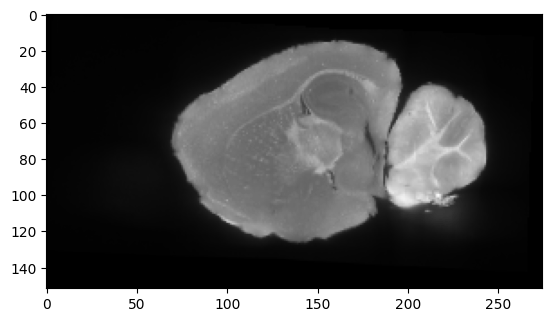

In [17]:
#check after ants file   cfos

after_ants_file = "after_ants.tif"


for i, sample in enumerate(sample_names):
    if i>0:
        continue
    path  =savedir+exp+"/" + sample +"/" +"cfos/"


    gz_file = path+"/"+ants_dir_name+"/"+'after_ants.nii.gz'
    if not os.path.exists(gz_file):
        print("{} not found".format(gz_file))
        continue


    nii_file = path+"/"+ants_dir_name+"/"+'after_ants.nii'
    output_tiff_file = path+"/"+ants_dir_name+"/"+ 'after_ants.tif'
#     if not os.path.exists(output_tiff_file):
    decompress_gzip(gz_file, nii_file)
    convert_nii_to_tiff(nii_file, output_tiff_file)



    img = tifffile.imread(output_tiff_file)

    x_num=img.shape[2]
    y_num=img.shape[1]
    z_num=img.shape[0]

    plt.imshow(img[:,:,150])
    plt.show()

In [ ]:
moving_points_csv_pre = "cell_table_all.csv"
moving_points_csv = "cell_table_before_all.csv"
moved_points_csv = "cell_table_after_all.csv" 
fol = "img_points"

rx = 50/50
Resized_um = 50
ants_dir_name = "ANTsR50"
ants_dir_name_after = "ANTsR20"
before_ants_file = "before_ants_{}um_R.tif".format(Resized_um)
before_ants_file_raw_norm = "raw_stacked_norm.tif"
vx=10
vx2=20
vx2=20
x_after = int(x_num * 50/vx2)
y_after = int(y_num * 50/vx2)
z_after =int(z_num * 50/vx2)


cr_num = 28
# block = ana_pi//cr_num
# block_re = ana_pi%cr_num

cores= 14

In [ ]:
# mak and save higher resoluted ANTs-normalized images

for i, sample in enumerate(sample_names):
#     if i<2:
#         continue
    if os.path.exists(savedir+exp+"/"+sample +"/cfos/"+ants_dir_name_after + "/after_ants.tif"):
        continue
        
    print(sample)
    os.makedirs(savedir+exp+"/"+sample+"/"+fol, exist_ok=True)
    if os.path.exists(savedir+ exp+"/"+sample+"/cfos/"+before_ants_file_raw_norm):
        img=tifffile.imread(savedir+ exp+"/"+sample+"/cfos/"+before_ants_file_raw_norm)
        # print(np.min(img))
#         plt.hist(np.ravel(img))
#         plt.show()
        # img_mask = img >  400
        # img= img*img_mask
        # plt.imshow(img[500,:,:])
        # plt.show()
        
        ind  = np.where(np.ravel(np.swapaxes(img > 400, 0, 2)))[0]
        # del img_mask
        x_ori = img.shape[2]
        y_ori = img.shape[1]
        z_ori = img.shape[0]
        
        intense = np.ravel(img.swapaxes(0,2))
        
        points = np.zeros((x_ori*y_ori*z_ori, 3), dtype="uint16")
        c=0
        for x in range(x_ori):
        #         if x >x_num/2:   #x=335~ha dir+other PC
        #             continue
            for y in range(y_ori):
            #         if y >382 and y<379:
            #             continue
                for z in range(z_ori):

                    points[c][0]=x*vx
                    points[c][1]=y*vx
                    points[c][2]=z*vx
                    c+=1
        points = points[ind].astype("uint16")
        intense = intense[ind].astype("uint16")
        
        
# points = pd.DataFrame({                      #Z>X
#         "X(um)":points[:,0],
#         "Y(um)":points[:,1],
#         "Z(um)":points[:,2]
#     })
    points = np.concatenate([points, intense.reshape(-1, 1)], axis=1).astype("uint16")
    print(points.shape)
    

    block = len(points)//cr_num
    block_re = len(points)%cr_num

    
#     for i in range(cr_num):
#         np.save(savedir+exp+"/"+sample+"/points_pre_all_{}".format(i), points[i*block:(i+1)*block])
    data_ants_path_p=savedir+exp+"/" + sample +"/" +"SYTOX-G/"
    Mapping = mapping_to_atlas(data_atlas_path, ants_dir_name, data_ants_path_p, before_ants_file)
    # ants points transfer 
    moved_points_dir = Mapping.ants_dst_dir +"/" +fol +"/"
    os.makedirs(moved_points_dir, exist_ok=True)
    
    if __name__ == "__main__":
        if block_re!=0:
            multi_save_re(cores, savedir, exp, sample, block, cr_num, fol)
        else:
            multi_save(cores, savedir, exp, sample, block, cr_num, fol)
        

#         if block_re!=0:
#             np.save(savedir+exp+"/"+sample+"/points_pre_all_{}".format(i+1), points[(i+1)*block:(i+1)*block+block_re])

    
#     if __name__ == "__main__":
        if block_re != 0:
            multi_points_re(cores, savedir, exp, sample, moved_points_dir, cr_num, fol)
        else:
            multi_points(cores, savedir, exp, sample, moved_points_dir, cr_num, fol)

    
    
        
        img = np.zeros((z_after, y_after, x_after),dtype=np.uint16)
#         moved_points_dir = savedir+exp+"/"+sample+"/SYTOX-G/"+ ants_dir_name +"/"

        if block_re != 0:
            for i in range(cr_num+1):

                intense_points_pkl = "cell_table_intense_all_{}.pkl".format(i)
                df = pd.read_pickle(moved_points_dir+ intense_points_pkl)
                df["X(um)"]=(df["X(um)"]/vx2).astype("int64").astype("uint16")
                df["Y(um)"]=(df["Y(um)"]/vx2).astype("int64").astype("uint16")
                df["Z(um)"]=(df["Z(um)"]/vx2).astype("int64").astype("uint16")
                df["intensity"] = df["intensity"].fillna(0).astype(np.uint16)
                df = df[(df['X(um)'].between(0, x_after-1)) & (df['Y(um)'].between(0, y_after-1)) & (df['Z(um)'].between(0, z_after-1))]
                data_array = df[['X(um)', 'Y(um)', 'Z(um)', 'intensity']].to_numpy()

                construct_voxel_grid(data_array,img)

            img=fill_zero_voxels_with_average(img)
    #         img = img.swapaxes(0, 2)
            if not os.path.exists(savedir+exp+"/"+sample +"/cfos/"+ants_dir_name_after):
                os.makedirs(savedir+exp+"/"+sample +"/cfos/"+ants_dir_name_after)
            tifffile.imwrite(savedir+exp+"/"+sample +"/cfos/"+ants_dir_name_after + "/after_ants.tif", img)
            del img
            gc.collect()

        else:
            for i in range(cr_num):

                intense_points_pkl = "cell_table_intense_all_{}.pkl".format(i)
                df = pd.read_pickle(moved_points_dir+ intense_points_pkl)
                df["X(um)"]=(df["X(um)"]/vx2).astype("int64").astype("uint16")
                df["Y(um)"]=(df["Y(um)"]/vx2).astype("int64").astype("uint16")
                df["Z(um)"]=(df["Z(um)"]/vx2).astype("int64").astype("uint16")
                df["intensity"] = df["intensity"].fillna(0).astype(np.uint16)
                df = df[(df['X(um)'].between(0, x_after-1)) & (df['Y(um)'].between(0, y_after-1)) & (df['Z(um)'].between(0, z_after-1))]
                data_array = df[['X(um)', 'Y(um)', 'Z(um)', 'intensity']].to_numpy()

                construct_voxel_grid(data_array,img)

            img=fill_zero_voxels_with_average(img)
    #         img = img.swapaxes(0, 2)
            if not os.path.exists(savedir+exp+"/"+sample +"/cfos/"+ants_dir_name_after):
                os.makedirs(savedir+exp+"/"+sample +"/cfos/"+ants_dir_name_after)
            tifffile.imwrite(savedir+exp+"/"+sample +"/cfos/"+ants_dir_name_after + "/after_ants.tif", img)
            print("save:", savedir+exp+"/"+sample +"/cfos/"+ants_dir_name_after + "/after_ants.tif")
            del img
            gc.collect()